In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import yaml
sys.path.append('../../src/')
from datamodule.datamodule import select_data

from torchmetrics.functional.image import peak_signal_noise_ratio as psnr
from torchmetrics.functional import mean_squared_error as mse
from torchmetrics.functional.image import structural_similarity_index_measure as ssim

import pytorch_lightning as pl
pl.seed_everything(123)

Seed set to 123


123

In [2]:
print(plt.style.available)
plt.style.use('seaborn-v0_8-dark-palette')
# https://www.color-hex.com/color-palette/1294
# https://personal.sron.nl/~pault/
# https://colorbrewer2.org/#type=sequential&scheme=BuPu&n=3

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
path_data = '../../data/baseline/'
path_results = '../../results/baseline_image_analysis'
os.makedirs(path_results, exist_ok=True)
files = os.listdir(path_data)
files = [os.path.join(path_data,f) for f in files if f.endswith('.pt')]

## Histogram of classes

In [4]:
train_classes = []
valid_classes = []

for f in tqdm(files):
    data = torch.load(f, weights_only=True)
    if 'train' in f:
        train_classes.append(torch.argmax(data['target']))
    elif 'valid' in f:
        valid_classes.append(torch.argmax(data['target']))
    else:
        pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.59it/s]


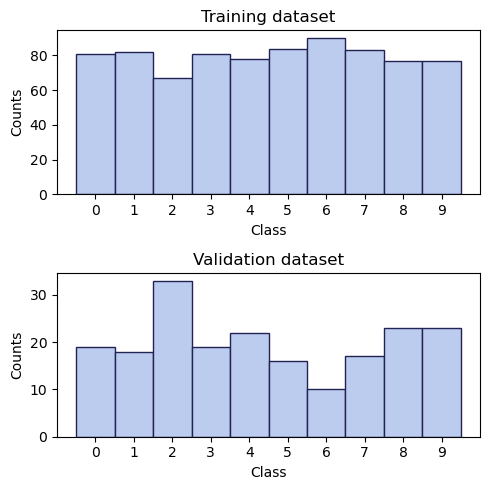

In [5]:
n_bins = 10
fig, ax = plt.subplots(2, 1, figsize=(5,5))
style = {'facecolor': '#bbccee', 'edgecolor': '#222255', 'linewidth': 1}
# We can set the number of bins with the *bins* keyword argument.
n, bins_train, patches = ax[0].hist(train_classes, bins=n_bins, **style)
n, bins_valid, patches = ax[1].hist(valid_classes, bins=n_bins, **style)

ax[0].set_title("Training dataset")
ax[1].set_title("Validation dataset")
bin_centers = 0.5 * np.diff(bins_train) + bins_train[:-1]

for a in ax.flatten():
    a.set_xticks(bin_centers, [i for i in range(0,10)])
    a.set_ylabel("Counts")
    a.set_xlabel("Class")
plt.tight_layout()
fig.savefig(os.path.join(path_results, 'dataset_histogram.pdf'))

## Images

In [6]:
# Get 3 random indices
indices = torch.randint(low=0, high=len(files), size=(3,))

simulation_images = []
bench_images = []
ideal_images = []

for i in indices:
    data = torch.load(files[i], weights_only=True)
    simulation_images.append(data['sim_output'].squeeze().detach())
    bench_images.append(data['bench_image'].squeeze())
    ideal_images.append(data['resampled_sample'].squeeze())
bench_images_normalized = [(i-torch.min(i)) / torch.max(i) for i in bench_images]
simulation_images_normalized = [(i-torch.min(i)) / torch.max(i) for i in simulation_images]

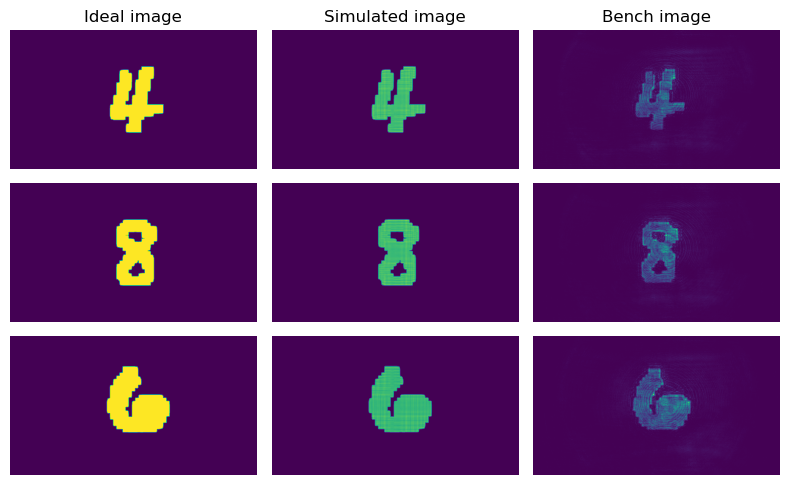

In [7]:
fig, ax = plt.subplots(3,3,figsize=(8,5))

for i in range(len(indices)):
    ax[i][0].imshow(ideal_images[i], cmap='viridis')
    ax[i][1].imshow(simulation_images[i], cmap='viridis')
    ax[i][2].imshow(bench_images[i], cmap='viridis')

ax[0][0].set_title("Ideal image")
ax[0][1].set_title("Simulated image")
ax[0][2].set_title("Bench image")

for a in ax.flatten():
    a.grid(False)
    a.axis(False)
plt.tight_layout()
fig.savefig(os.path.join(path_results, 'image_examples.pdf'))

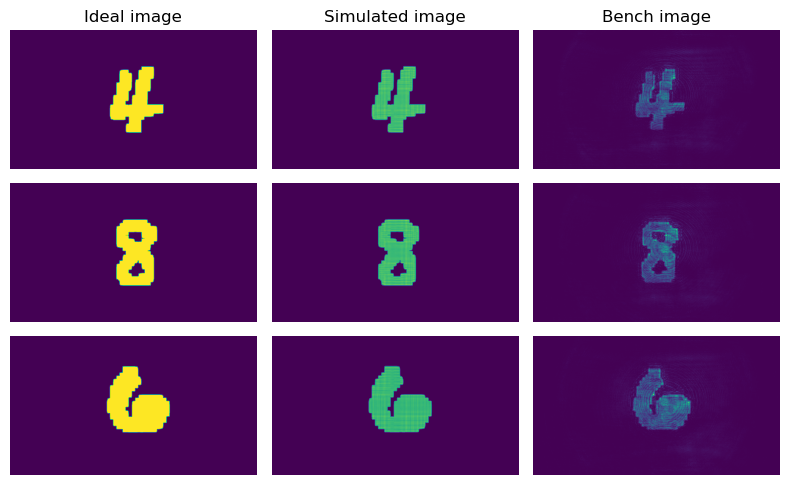

In [8]:
fig, ax = plt.subplots(3,3,figsize=(8,5))

for i in range(len(indices)):
    ax[i][0].imshow(ideal_images[i], cmap='viridis', vmin=0, vmax=1)
    ax[i][1].imshow(simulation_images_normalized[i], cmap='viridis', vmin=0, vmax=1)
    ax[i][2].imshow(bench_images_normalized[i], cmap='viridis', vmin=0, vmax=1)

ax[0][0].set_title("Ideal image")
ax[0][1].set_title("Simulated image")
ax[0][2].set_title("Bench image")

for a in ax.flatten():
    a.grid(False)
    a.axis(False)
plt.tight_layout()
fig.savefig(os.path.join(path_results, 'image_examples_normalized.pdf'))

/tmp/ipykernel_614682/168406953.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[i][0].imshow(np.abs(ideal_images[i] - simulation_images[i]), cmap='viridis', vmin=0, vmax=1)
/tmp/ipykernel_614682/168406953.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[i][1].imshow(np.abs(ideal_images[i] - bench_images[i]), cmap='viridis', vmin=0, vmax=1)
/tmp/ipykernel_614682/168406953.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[i][2].imshow(np.abs(simulation_images[i] - bench_images[i]), cmap='viridis', vmin=0, vmax=1)


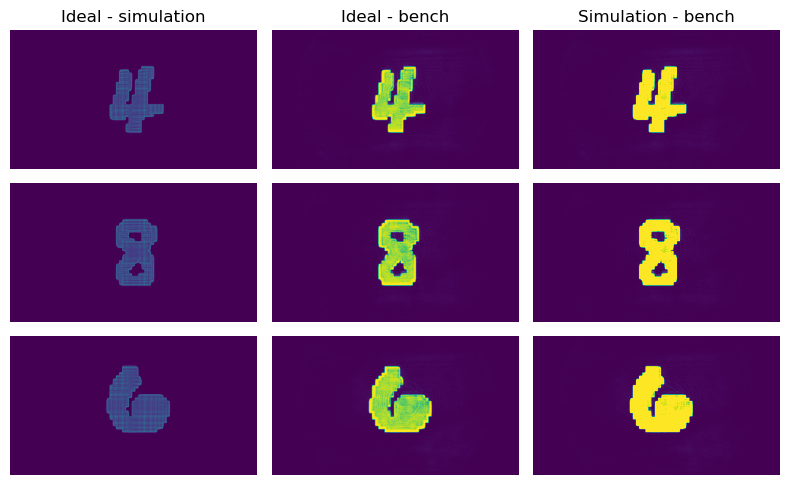

In [10]:
fig, ax = plt.subplots(3,3,figsize=(8,5))

for i in range(len(indices)):
    ax[i][0].imshow(np.abs(ideal_images[i] - simulation_images[i]), cmap='viridis', vmin=0, vmax=1)
    ax[i][1].imshow(np.abs(ideal_images[i] - bench_images[i]), cmap='viridis', vmin=0, vmax=1)
    ax[i][2].imshow(np.abs(simulation_images[i] - bench_images[i]), cmap='viridis', vmin=0, vmax=1)

ax[0][0].set_title("Ideal - simulation")
ax[0][1].set_title("Ideal - bench")
ax[0][2].set_title("Simulation - bench")

for a in ax.flatten():
    a.grid(False)
    a.axis(False)
plt.tight_layout()
fig.savefig(os.path.join(path_results, 'image_difference.pdf'))

/tmp/ipykernel_614682/4106523029.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[i][0].imshow(np.abs(ideal_images[i] - simulation_images_normalized[i]), cmap='viridis', vmin=0, vmax=1)
/tmp/ipykernel_614682/4106523029.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[i][1].imshow(np.abs(ideal_images[i] - bench_images_normalized[i]), cmap='viridis', vmin=0, vmax=1)
/tmp/ipykernel_614682/4106523029.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[i][2].imshow(np.abs(simulation_images_normalized[i] - bench_images_normalized[i]), cmap='viridis', vmin=0, vmax=1)


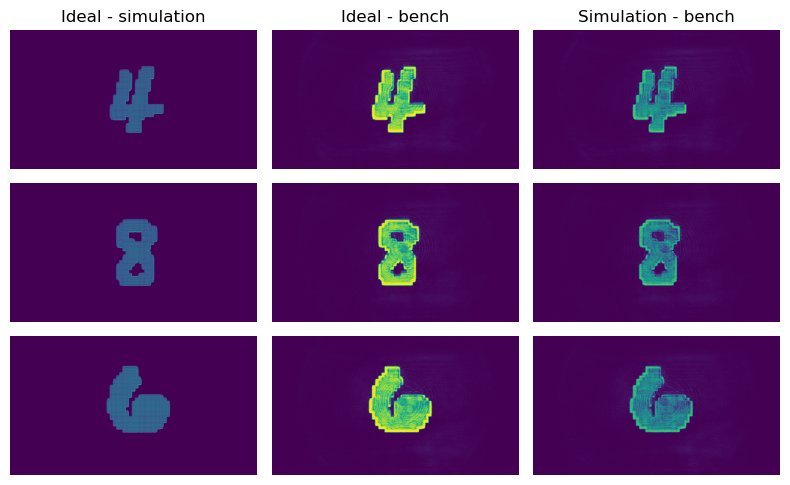

In [11]:
fig, ax = plt.subplots(3,3,figsize=(8,5))

for i in range(len(indices)):
    ax[i][0].imshow(np.abs(ideal_images[i] - simulation_images_normalized[i]), cmap='viridis', vmin=0, vmax=1)
    ax[i][1].imshow(np.abs(ideal_images[i] - bench_images_normalized[i]), cmap='viridis', vmin=0, vmax=1)
    ax[i][2].imshow(np.abs(simulation_images_normalized[i] - bench_images_normalized[i]), cmap='viridis', vmin=0, vmax=1)

ax[0][0].set_title("Ideal - simulation")
ax[0][1].set_title("Ideal - bench")
ax[0][2].set_title("Simulation - bench")

for a in ax.flatten():
    a.grid(False)
    a.axis(False)
plt.tight_layout()
fig.savefig(os.path.join(path_results, 'image_difference_normalized.pdf'))

## Metrics

In [9]:
sim_2_bench_mse = []
sim_2_ideal_mse = []
bench_2_ideal_mse = []

sim_2_bench_psnr = []
sim_2_ideal_psnr = []
bench_2_ideal_psnr = []

sim_2_bench_ssim = []
sim_2_ideal_ssim = []
bench_2_ideal_ssim = []

sim_max = []
bench_max = []
sim_min = []
bench_min = []
sim_mean = []
bench_mean = []
for f in tqdm(files):
    data = torch.load(f, weights_only=True)
    simulation_image = data['sim_output'].squeeze()
    bench_image = data['bench_image'].squeeze()
    ideal_image = data['resampled_sample'].squeeze()
    sim_2_ideal_mse.append(mse(ideal_image, simulation_image))
    sim_2_bench_mse.append(mse(simulation_image, bench_image))
    bench_2_ideal_mse.append(mse(ideal_image, bench_image))

    sim_2_ideal_psnr.append(psnr(ideal_image, simulation_image))
    sim_2_bench_psnr.append(psnr(simulation_image, bench_image))
    bench_2_ideal_psnr.append(psnr(ideal_image, bench_image))

    ideal_image_shape = ideal_image.shape
    simulation_image_shape = simulation_image.shape
    bench_image_shape = bench_image.shape

    ideal_image = ideal_image.view(1,1,ideal_image_shape[-2], ideal_image_shape[-1])
    simulation_image = simulation_image.view(1,1,simulation_image_shape[-2], simulation_image_shape[-1])
    bench_image = bench_image.view(1,1,bench_image_shape[-2], bench_image_shape[-1])
    
    sim_2_ideal_ssim.append(ssim(ideal_image, simulation_image))
    sim_2_bench_ssim.append(ssim(simulation_image, bench_image))
    bench_2_ideal_ssim.append(ssim(ideal_image, bench_image))

    sim_max.append(torch.max(simulation_image))
    bench_max.append(torch.max(bench_image))
    sim_min.append(torch.min(simulation_image))
    bench_min.append(torch.min(bench_image))
    sim_mean.append(torch.mean(simulation_image))
    bench_mean.append(torch.mean(bench_image))

  0%|                                                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
labels = ['Simulation to ideal', 'Bench to ideal', 'Simulation to bench']

fig, ax = plt.subplots(3,1,figsize=(5,8))

bp0 = ax[0].violinplot([sim_2_ideal_mse, bench_2_ideal_mse, sim_2_bench_mse], points=800, showmeans=True)
ax[0].set_xticks([i+1 for i in range(len(labels))], labels)
ax[0].set_ylabel(r'MSE $\downarrow$')

bp1 = ax[1].violinplot([sim_2_ideal_psnr, bench_2_ideal_psnr, sim_2_bench_psnr], points=800, showmeans=True)
ax[1].set_xticks([i+1 for i in range(len(labels))], labels)
ax[1].set_ylabel(r'PSNR $\uparrow$')

bp2 = ax[2].violinplot([sim_2_ideal_ssim, bench_2_ideal_ssim, sim_2_bench_ssim], points=800, showmeans=True)
ax[2].set_xticks([i+1 for i in range(len(labels))], labels)
ax[2].set_ylabel(r'SSIM $\uparrow$')
plt.tight_layout()
fig.savefig(os.path.join(path_results, 'image_comparison_violin.pdf'))

In [ ]:
labels = ['Simulation', 'Bench']

fig, ax = plt.subplots(1,1,figsize=(5,4))

bp0 = ax.violinplot([sim_max, bench_max], points=800, showmeans=True)
ax.set_xticks([i+1 for i in range(len(labels))], labels)
ax.set_ylabel('Max pixel value')
plt.tight_layout()
fig.savefig(os.path.join(path_results, 'max_pixel_values_violin.pdf'))

In [ ]:
labels = ['Simulation', 'Bench']

fig, ax = plt.subplots(1,1,figsize=(5,4))

bp0 = ax.violinplot([sim_min, bench_min], points=800, showmeans=True)
ax.set_xticks([i+1 for i in range(len(labels))], labels)
ax.set_ylabel('Min pixel value')
plt.tight_layout()
fig.savefig(os.path.join(path_results, 'min_pixel_values_violin.pdf'))

In [ ]:
labels = ['Simulation', 'Bench']

fig, ax = plt.subplots(1,1,figsize=(5,4))

bp0 = ax.violinplot([sim_mean, bench_mean], points=800, showmeans=True)
ax.set_xticks([i+1 for i in range(len(labels))], labels)
ax.set_ylabel('Mean pixel value')
plt.tight_layout()
fig.savefig(os.path.join(path_results, 'mean_pixel_values_violin.pdf'))

## Signal vs noise count statistics